In [9]:
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

In [10]:
tfds.list_builders()


['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'cos_e',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'eraser_multi_rc',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flic',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'gr

In [11]:
ds, ds_info = tfds.load('tf_flowers', split='train', with_info=True)



local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


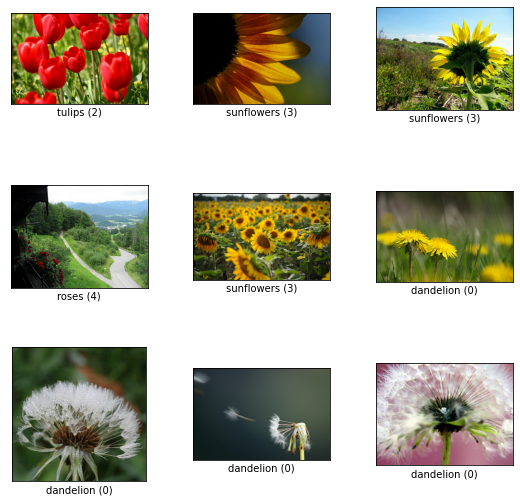

In [12]:
fig = tfds.show_examples(ds_info, ds)


In [195]:
!rm -rf images
!mkdir images

In [196]:
from absl import logging

from tensorflow_datasets.core import dataset_utils
from tensorflow_datasets.core import features as features_lib
from PIL import Image
from efficientnet.preprocessing import center_crop_and_resize


def save_examples(ds_info, ds, num_examples = 10, folder=".", image_key=None):
  """Save images from an image classification dataset.

  Only works with datasets that have 1 image feature and optionally 1 label
  feature (both inferred from `ds_info`). Note the dataset should be unbatched.

  Usage:

  ```python
  ds, ds_info = tfds.load('cifar10', split='train', with_info=True)
  fig = save_examples(ds_info, ds)
  ```

  Args:
    ds_info: The dataset info object to which extract the label and features
      info. Available either through `tfds.load('mnist', with_info=True)` or
      `tfds.builder('mnist').info`
    ds: `tf.data.Dataset`. The tf.data.Dataset object to visualize. Examples
      should not be batched.
    num_examples: `int`. Number of examples to save
    folder: `str`. Where to save images
    image_key: `string`, name of the feature that contains the image. If not
       set, the system will try to auto-detect it.

  Returns:
  """

  if not image_key:
    # Infer the image and label keys
    image_keys = [
        k for k, feature in ds_info.features.items()
        if isinstance(feature, features_lib.Image)
    ]

    if not image_keys:
      raise ValueError(
          "Visualisation not supported for dataset `{}`. Was not able to "
          "auto-infer image.".format(ds_info.name))

    if len(image_keys) > 1:
      raise ValueError(
          "Multiple image features detected in the dataset. Using the first one. You can "
          "use `image_key` argument to override. Images detected: %s" %
          (",".join(image_keys)))

    image_key = image_keys[0]

  label_keys = [
      k for k, feature in ds_info.features.items()
      if isinstance(feature, features_lib.ClassLabel)
  ]

  label_key = label_keys[0] if len(label_keys) == 1 else None
  if not label_key:
    logging.info("Was not able to auto-infer label.")

  examples = list(dataset_utils.as_numpy(ds.take(num_examples)))

  for i, ex in enumerate(examples):
    if not isinstance(ex, dict):
      raise ValueError(
          "tfds.show_examples requires examples as `dict`, with the same "
          "structure as `ds_info.features`. It is currently not compatible "
          "with `as_supervised=True`. Received: {}".format(type(ex)))

    # Plot the image
    image = ex[image_key]
    if len(image.shape) != 3:
      raise ValueError(
          "Image dimension should be 3. tfds.show_examples does not support "
          "batched examples or video.")
    _, _, c = image.shape
    if c == 1:
      image = image.reshape(image.shape[:2])
    image = center_crop_and_resize(image, 224).astype(np.uint8)
    im = Image.fromarray(image)
    # Plot the label
    if label_key:
      label = ex[label_key]
      label_str = ds_info.features[label_key].int2str(label)
    else:
      label_str = ""
    im.save(f"{folder}/image_{label_str}_{i}.jpeg")

save_examples(ds_info, ds, 1000, "images")

In [197]:
!du -hs images

14M	images


In [1]:
!pip install efficientnet

In [198]:
import tensorflow as tf
import numpy as np
import time

from efficientnet.tfkeras import EfficientNetB0
import numpy as np
import pyarrow.parquet as pq
import pyarrow as pa


def list_files(images_path):
    return tf.data.Dataset.list_files(images_path + '/*', shuffle=False).cache()


def process_path(file_path):
    parts = tf.strings.split(file_path, '/')
    image_name = tf.strings.split(parts[-1], '.')[0]
    raw = tf.io.read_file(file_path)
    return raw, image_name


def read_data_from_files(list_ds):
    return list_ds.map(process_path,
                       num_parallel_calls=tf.data.experimental.AUTOTUNE)#.apply(tf.data.experimental.ignore_errors())


def images_to_embeddings(model, dataset, batch_size):
    return model.predict(dataset.batch(batch_size).map(lambda image_raw, image_name: image_raw), verbose=1)


def save_embeddings_ds_to_parquet(embeddings, dataset, path):
    embeddings = pa.array(embeddings.tolist(), type=pa.list_(pa.float32()))
    image_names = pa.array(dataset.map(lambda image_raw, image_name: image_name).as_numpy_iterator())
    table = pa.Table.from_arrays([image_names, embeddings], ["image_name", "embedding"])
    pq.write_table(table, path)


def compute_save_embeddings(list_ds, folder, num_shards, model, batch_size):
    start = time.time()
    for shard_id in range(0, num_shards):
        shard_list = list_ds.shard(num_shards=num_shards, index=shard_id)
        shard = read_data_from_files(shard_list)
        embeddings = images_to_embeddings(model, shard, batch_size)
        print("Shard " + str(shard_id) + " done after " + str(int(time.time() - start)) + "s")
        save_embeddings_ds_to_parquet(embeddings, shard,
                                      folder + "/part-" + "{:03d}".format(shard_id) + ".parquet")
        print("Shard " + str(shard_id) + " saved after " + str(int(time.time() - start)) + "s")
    print("Total time : " + str(int(time.time() - start)))


def run_inference(image_folder, output_folder, num_shards=100, batch_size=1000):
    model = EfficientNetB0(weights='imagenet', include_top=False, pooling="avg")
    list_ds = list_files(image_folder)
    compute_save_embeddings(list_ds, output_folder, num_shards, model, batch_size)



In [199]:
#from inference import list_files, compute_save_embeddings, read_data_from_files,\
#images_to_embeddings, save_embeddings_ds_to_parquet
from efficientnet.tfkeras import EfficientNetB0
import tensorflow as tf
import numpy as np
import time


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def serialize_example(image, image_name):
    feature = {
        'image_name': _bytes_feature(image_name),
        'image': _bytes_feature(image)
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


def tf_serialize_example(image, image_name):
    tf_string = tf.py_function(
        serialize_example,
        (image, image_name),
        tf.string)
    return tf.reshape(tf_string, ())


def process_path(file_path):
    parts = tf.strings.split(file_path, '/')
    image_name = tf.strings.split(parts[-1], '.')[0]
    raw = tf.io.read_file(file_path)
    return raw, image_name


def read_image_file_write_tfrecord(files_ds, output_filename):
    image_ds = files_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    serialized_features_dataset = image_ds.map(tf_serialize_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    writer = tf.data.experimental.TFRecordWriter(output_filename)
    writer.write(serialized_features_dataset)


def image_files_to_tfrecords(list_ds, output_folder, num_shard):
    start = time.time()
    for shard_id in range(0, num_shard):
        shard_list = list_ds.shard(num_shards=num_shard, index=shard_id)
        read_image_file_write_tfrecord(shard_list, output_folder + "/part-" + "{:03d}".format(shard_id) + ".tfrecord")
        print("Shard " + str(shard_id) + " saved after " + str(int(time.time() - start)) + "s")


feature_description = {
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string)
}


def _parse_function(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)


def preprocess_image(d):
    image_name = d['image_name']
    raw = d['image']
    image = tf.image.decode_jpeg(raw)
    image = tf.image.convert_image_dtype(image, tf.float32)

    return image, image_name


def read_tfrecord(filename):
    filenames = [filename]
    raw_dataset = tf.data.TFRecordDataset(filenames)
    return raw_dataset \
        .map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .apply(tf.data.experimental.ignore_errors())


def tfrecords_to_write_embeddings(tfrecords_folder, output_folder, model, batch_size):
    tfrecords = [f.numpy().decode("utf-8") for f in \
                 tf.data.Dataset.list_files(tfrecords_folder + "/*.tfrecord", shuffle=False)]
    start = time.time()
    for shard_id, tfrecord in enumerate(tfrecords):
        shard = read_tfrecord(tfrecord)
        embeddings = images_to_embeddings(model, shard, batch_size)
        print("")
        print("Shard " + str(shard_id) + " done after " + str(int(time.time() - start)) + "s")
        save_embeddings_ds_to_parquet(embeddings, shard,
                                      output_folder + "/part-" + "{:03d}".format(shard_id) + ".parquet")
        print("Shard " + str(shard_id) + " saved after " + str(int(time.time() - start)) + "s")

In [200]:
# from inference import list_files
# from tfrecord_reader_writer import image_files_to_tfrecords

def write_tfrecord(image_folder, output_folder, num_shards=100):
    list_ds = list_files(image_folder)
    image_files_to_tfrecords(list_ds, output_folder, num_shards)




In [201]:
!rm -rf tfrecords
!mkdir tfrecords

In [202]:
write_tfrecord("images", "tfrecords", 1)

Shard 0 saved after 0s


In [203]:
!du -h -s tfrecords

12M	tfrecords


In [204]:
!rm -rf embeddings
!mkdir embeddings

In [205]:
#from tfrecord_reader_writer import tfrecords_to_write_embeddings
from efficientnet.tfkeras import EfficientNetB0


def run_inference(tfrecords_folder, output_folder, batch_size=1000):
    model = EfficientNetB0(weights='imagenet', include_top=False, pooling="avg")
    tfrecords_to_write_embeddings(tfrecords_folder, output_folder, model, batch_size)



In [206]:
run_inference("tfrecords", "embeddings", 1000)

1/1 [==============================] - 0s 149ms/step

Shard 0 done after 66s
Shard 0 saved after 67s


In [207]:
emb = pq.read_table("embeddings").to_pandas()

In [83]:
emb

,image_name,embedding
0,b'image_daisy_13',"[-0.098760575, -0.122217394, -0.18710428, -0.1..."
1,b'image_daisy_15',"[-0.13827726, -0.14196308, -0.15896742, -0.136..."
2,b'image_daisy_16',"[-0.10091114, 0.16872205, -0.16353016, -0.1254..."
3,b'image_daisy_24',"[0.37878612, 0.53823364, -0.08176956, -0.15575..."
4,b'image_daisy_25',"[-0.070991196, -0.10239971, 0.14434339, -0.100..."
...,...,...
95,b'image_tulips_82',"[-0.13556243, -0.10779267, -0.09632701, -0.223..."
96,b'image_tulips_83',"[-0.12321091, -0.13933122, -0.044730842, -0.17..."
97,b'image_tulips_86',"[-0.121702425, -0.20314246, 0.0074746073, -0.0..."
98,b'image_tulips_94',"[-0.0017160092, -0.14209984, -0.120488204, -0...."


In [216]:
!du -hs embeddings

5.5M	embeddings


In [90]:
!pip install faiss_cpu

    100% |████████████████████████████████| 6.8MB 5.9MB/s 
distributed 1.21.8 requires msgpack, which is not installed.


In [208]:
id_to_name = {k:v.decode("utf-8") for k,v in enumerate(list(emb["image_name"]))}
name_to_id = {v:k for k,v in id_to_name.items()}

In [209]:
embgood = np.stack(emb["embedding"].to_numpy())

In [210]:
embgood

array([[-0.03543991, -0.15163243, -0.13496652, ...,  0.01907586,
        -0.13296674,  0.5373452 ],
       [-0.15745671, -0.12783383, -0.17943217, ...,  0.31156987,
        -0.11525813,  0.4480593 ],
       [-0.1792364 , -0.12422188, -0.16109551, ...,  0.00203623,
        -0.20498396,  0.19341025],
       ...,
       [-0.09315211, -0.19348016, -0.11206696, ..., -0.17900732,
        -0.13366303,  0.84888387],
       [-0.14543465, -0.1455583 , -0.15405498, ..., -0.16430707,
        -0.00788436,  0.3793269 ],
       [-0.13419451, -0.10744577, -0.12787189, ..., -0.13693443,
        -0.07209311,  0.21788447]], dtype=float32)

In [143]:
!pip install -q ipyplot

distributed 1.21.8 requires msgpack, which is not installed.


In [231]:
import faiss
d = 1280
xb = embgood
index = faiss.IndexFlatIP(d)
index.add(xb)

In [212]:
def search(emb, k=5):
  D, I = index.search(np.expand_dims(emb, 0), k)     # actual search
  return list(zip(D[0], [id_to_name[x] for x in I[0]]))


In [252]:
from IPython.display import Image, display
from ipywidgets import widgets, HBox, VBox
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

def display_picture(image_name):
  display(Image(filename=f"images/{image_name}.jpeg"))

def display_results(results):
  hbox = HBox([VBox([widgets.Label(f"{distance:.2f} {image_name}"), widgets.Image(value=open(f"images/{image_name}.jpeg", 'rb').read())]) for distance, image_name in results])
  display(hbox)

image_daisy_677


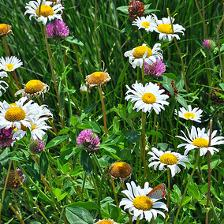

In [253]:
print(id_to_name[p])
display_picture(id_to_name[p])
display_results(search(xb[p]))

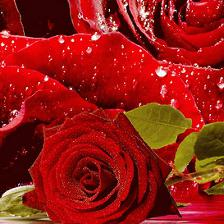

In [255]:
p = "image_roses_363"
display_picture(p)
display_results(search(xb[name_to_id[p]]))

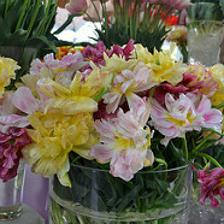

In [256]:
p = "image_tulips_372"
display_picture(p)
display_results(search(xb[name_to_id[p]]))

In [224]:
name_to_id.keys()

dict_keys(['image_daisy_102', 'image_daisy_104', 'image_daisy_114', 'image_daisy_121', 'image_daisy_126', 'image_daisy_128', 'image_daisy_129', 'image_daisy_13', 'image_daisy_131', 'image_daisy_140', 'image_daisy_15', 'image_daisy_151', 'image_daisy_158', 'image_daisy_16', 'image_daisy_170', 'image_daisy_178', 'image_daisy_183', 'image_daisy_184', 'image_daisy_190', 'image_daisy_192', 'image_daisy_218', 'image_daisy_235', 'image_daisy_237', 'image_daisy_24', 'image_daisy_240', 'image_daisy_25', 'image_daisy_250', 'image_daisy_252', 'image_daisy_253', 'image_daisy_254', 'image_daisy_255', 'image_daisy_26', 'image_daisy_266', 'image_daisy_269', 'image_daisy_273', 'image_daisy_276', 'image_daisy_284', 'image_daisy_287', 'image_daisy_288', 'image_daisy_302', 'image_daisy_310', 'image_daisy_311', 'image_daisy_312', 'image_daisy_318', 'image_daisy_325', 'image_daisy_326', 'image_daisy_329', 'image_daisy_333', 'image_daisy_335', 'image_daisy_360', 'image_daisy_387', 'image_daisy_396', 'image_

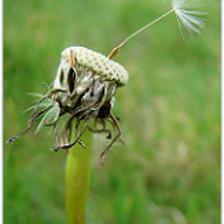

In [258]:
p = "image_dandelion_172"
display_picture(p)
display_results(search(xb[name_to_id[p]]))